### Importações das bibliotecas


In [24]:
# serialização de dados
import pickle

# tratamento e visualização de dados
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# divisão em treino e teste, escalona e faz encoding de variáveis categóricas
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler

# Discretização de features
from feature_engine.discretisation import EqualFrequencyDiscretiser

# métricas de performance de modelos
# classification_report, accuracy_score, f1_score, average_precision_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# importamos a árvore de decisão
from sklearn.tree import DecisionTreeClassifier
# importando randomforestclassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# importando o classificador XGBoost
from xgboost import XGBClassifier
# Importando o classificador Support Vector Machines
from sklearn.svm import SVC

# Para a Validação Cruzada
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline

# Tunagem de Hiperparâmetros
import optuna

### Importando a base de dados

In [2]:
with open('EDA_df.pkl', mode='rb') as f:
    df = pickle.load(f)

### Funções que utilizaremos

In [3]:
def treinar_modelo(modelo, X: pd.DataFrame, y: pd.Series, report: bool=False) -> str:      
    # Criando o StratifiedKFold
    k = 10
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=47)

    # Definindo um pipeline com StandardScaler e LogisticRegression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('gaussiannb', modelo)
    ])

    # Definindo as métricas
    scoring = ['precision_weighted', 'recall_weighted']

    # Calculando as métricas usando cross_validate
    scores = cross_validate(pipeline, X, y, cv=skf, scoring=scoring, return_train_score=False)
        
    # treinando o modelo para obter a matriz de confusao
    train_index, test_index = next(skf.split(X,y))
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    
    if report:
        
        # Exibindo as métricas finais
        print(f"Média da Precisão (Weighted): {scores['test_precision_weighted'].mean():.3f}")
        print(f"Média da Revocação (Weighted): {scores['test_recall_weighted'].mean():.3f}")
            
        # plotando a matriz de confusão da cross_validate
        matriz_confusao = confusion_matrix(y_test, y_pred)
        sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues')

        # Configurações do gráfico
        plt.title('Matriz de confusão')
        plt.xlabel('Valor Predito')
        plt.ylabel('Valor Real')
        plt.show();
    
    return pipeline, X_test, y_test, y_pred

# Modelagem
### Feature Engineering
- EqualFrequencyDiscretiser
- LabelEncoder

In [4]:
""" Criando as features abaixo:
 1. retorno_emprestimo = multiplicar taxa_juros_emprestimo por valor_emprestimo e somar ao valor_emprestimo
 2. proporcao_renda_emp = dividir renda por emprestimo
 3. ratio_emprego_credtio = tempo_emprego_cliente dividido por tempo_credito_cliente, dividir por zero = 0
 4. discretiser = dividir a coluna idade, tempo_emprego e tempo_credito em intervalos utilizando discretisers
 5. mean_valoremp_finalidade = média de valor_emprestimo para cada nota_emprestimo
"""
 
# 1. 
df['retorno_emprestimo'] = df['valor_emprestimo'] * (df['taxa_juros_emprestimo'] / 100 + 1)

# 2.
df['ratio_renda_emp'] = df['renda_cliente'] / df['valor_emprestimo']

# 3. 
df['ratio_emprego_credito'] = df['tempo_emprego_cliente'] / df['tempo_credito_cliente']

# 5.
df['ratio_taxaemp_finalidade'] = df.groupby(['nota_emprestimo'])['taxa_juros_emprestimo'].transform('mean')

# 4. Instanciando o discretizador
efd_disc = EqualFrequencyDiscretiser()

# Ajustando o discretizador aos dados
try:
    # Ajustando o discretizador aos dados
    df['EWB_idade'] = efd_disc.fit_transform(df[['idade_cliente']])
    df['EWB_tempo_emprego'] = efd_disc.fit_transform(df[['tempo_emprego_cliente']])
    df['EWB_tempo_credito'] = efd_disc.fit_transform(df[['tempo_credito_cliente']])
except Exception as e:
    print(f"Erro ao aplicar o EqualWidthDiscretiser: {e}")


In [5]:
df.dtypes

idade_cliente                        int16
renda_cliente                        int64
posse_residencia_cliente            object
tempo_emprego_cliente                int16
finalidade_emprestimo               object
nota_emprestimo                     object
valor_emprestimo                     int64
taxa_juros_emprestimo              float32
percentual_renda_emprestimo        float32
historico_inadimplencia_cliente      int16
tempo_credito_cliente                int16
status_emprestimo                    int16
retorno_emprestimo                 float64
ratio_renda_emp                    float64
ratio_emprego_credito              float64
ratio_taxaemp_finalidade           float32
EWB_idade                            int64
EWB_tempo_emprego                    int64
EWB_tempo_credito                    int64
dtype: object

In [6]:
# verificando os intervalos criados para a idade
df.groupby('EWB_idade').agg({'idade_cliente':['mean','min','max', 'size']})

idade_cliente              
                   mean min max  size
EWB_idade                            
0             21.740547  20  22  4390
1             23.000000  23  23  3518
2             24.000000  24  24  3214
3             25.000000  25  25  2783
4             26.000000  26  26  2256
5             27.000000  27  27  1925
6             28.478288  28  29  3201
7             30.904096  30  32  3076
8             34.310303  33  36  2475
9             42.468374  37  84  2577

In [7]:
# verificando os intervalos criados para o tempo de serviço
df.groupby('EWB_tempo_emprego').agg({'EWB_tempo_emprego':['mean','min','max', 'size']})

EWB_tempo_emprego              
                               mean min max  size
EWB_tempo_emprego                                
0                               0.0   0   0  7172
1                               1.0   1   1  3463
2                               2.0   2   2  3130
3                               3.0   3   3  2569
4                               4.0   4   4  2712
5                               5.0   5   5  2392
6                               6.0   6   6  3498
7                               7.0   7   7  1854
8                               8.0   8   8  2625

In [8]:
# verificando os intervalos criados para o tempo de crédito em registro
df.groupby('EWB_tempo_credito').agg({'EWB_tempo_credito':['mean','min','max', 'size']})

EWB_tempo_credito               
                               mean min max   size
EWB_tempo_credito                                 
0                               0.0   0   0  10770
1                               1.0   1   1   5393
2                               2.0   2   2   1699
3                               3.0   3   3   3394
4                               4.0   4   4   3407
5                               5.0   5   5   2106
6                               6.0   6   6   2646

In [9]:
# visualizando o dataset após implementação
df.head(15)

,idade_cliente,renda_cliente,posse_residencia_cliente,tempo_emprego_cliente,finalidade_emprestimo,nota_emprestimo,valor_emprestimo,taxa_juros_emprestimo,percentual_renda_emprestimo,historico_inadimplencia_cliente,tempo_credito_cliente,status_emprestimo,retorno_emprestimo,ratio_renda_emp,ratio_emprego_credito,ratio_taxaemp_finalidade,EWB_idade,EWB_tempo_emprego,EWB_tempo_credito
0,22,59000,Alugada,23,Pessoal,D,35000,16.020000,0.59,1,3,1,40606.999993,1.685714,7.666667,15.361643,0,8,0
1,21,9600,Própria,5,Educação,B,1000,11.140000,0.10,0,2,0,1111.400008,9.600000,2.500000,10.995920,0,4,0
2,25,9600,Hipoteca,1,Médico,C,5500,12.870000,0.57,0,3,1,6207.850099,1.745455,0.333333,13.464475,3,0,0
3,23,65500,Alugada,4,Médico,C,35000,15.230000,0.53,0,2,1,40330.500007,1.871429,2.000000,13.464475,1,3,0
4,24,54400,Alugada,8,Médico,C,35000,14.270000,0.55,1,4,1,39994.498491,1.554286,2.000000,13.464475,2,6,1
5,21,9900,Própria,2,Empreendimento,A,2500,7.140000,0.25,0,2,1,2678.500116,3.960000,1.000000,7.327100,0,1,0
6,26,77100,Alugada,8,Educação,B,35000,12.420000,0.45,0,3,1,39346.999526,2.202857,2.666667,10.995920,4,6,0
7,24,78956,Alugada,5,Médico,B,35000,11.110000,0.44,0,4,1,38888.498545,2.255886,1.250000,10.995920,2,4,1
8,24,83000,Alugada,8,Pessoal,A,35000,8.900000,0.42,0,2,1,38114.999533,2.371429,4.000000,7.327100,2,6,0
9,21,10000,Própria,6,Empreendimento,D,1600,14.740000,0.16,0,3,1,1835.840034,6.250000,2.000000,15.361643,0,5,0


In [10]:
df.columns

Index(['idade_cliente', 'renda_cliente', 'posse_residencia_cliente',
       'tempo_emprego_cliente', 'finalidade_emprestimo', 'nota_emprestimo',
       'valor_emprestimo', 'taxa_juros_emprestimo',
       'percentual_renda_emprestimo', 'historico_inadimplencia_cliente',
       'tempo_credito_cliente', 'status_emprestimo', 'retorno_emprestimo',
       'ratio_renda_emp', 'ratio_emprego_credito', 'ratio_taxaemp_finalidade',
       'EWB_idade', 'EWB_tempo_emprego', 'EWB_tempo_credito'],
      dtype='object')

In [11]:
# instanciando o LabelEncoder
label_encoder_residencia = LabelEncoder()
label_encoder_finalidade_emp = LabelEncoder()
label_encoder_nota_emprestimo = LabelEncoder()

# encoding de features categóricas
df.posse_residencia_cliente = label_encoder_residencia.fit_transform(df.posse_residencia_cliente)
df.finalidade_emprestimo = label_encoder_finalidade_emp.fit_transform(df.finalidade_emprestimo)
df.nota_emprestimo = label_encoder_nota_emprestimo.fit_transform(df.nota_emprestimo)

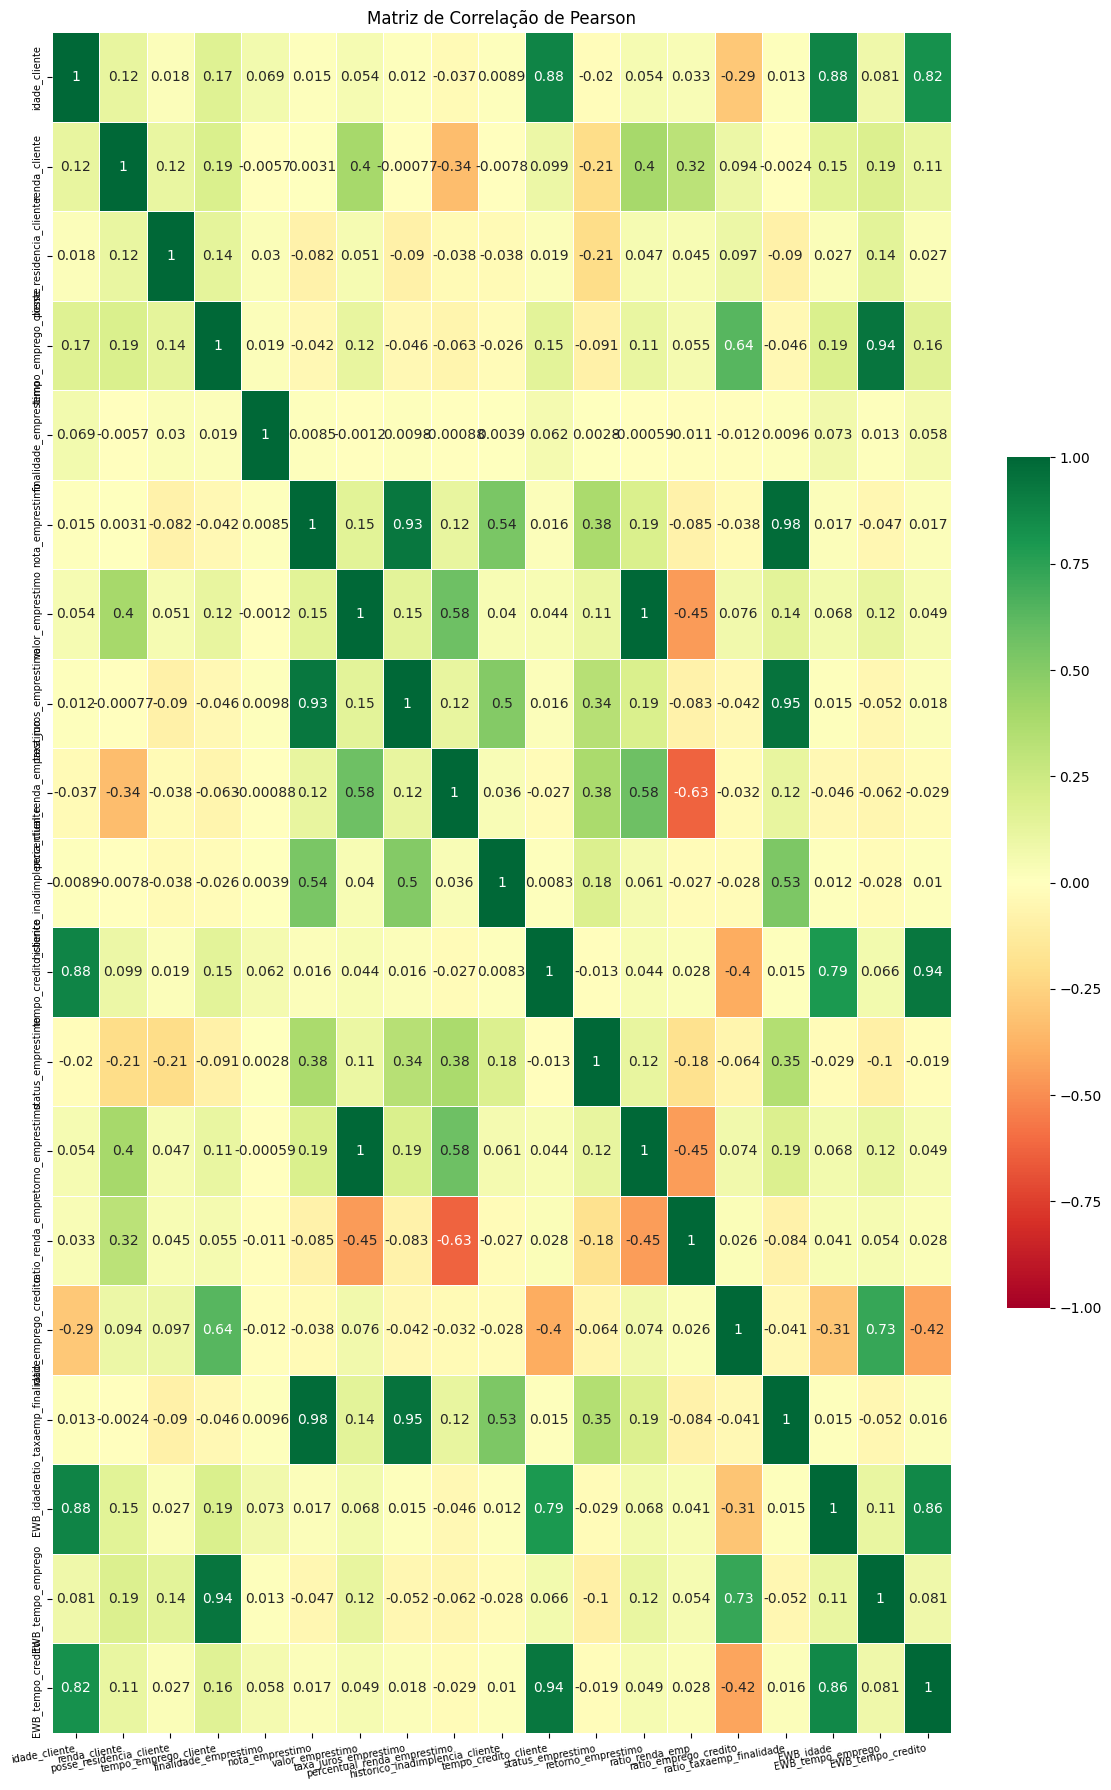

In [12]:
# Verificando a Correlação de Pearson para as variáveis do dataset
plt.figure(figsize=(12,18))
# Selecionar apenas as colunas numéricas
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()

# Calcular a matriz de correlação de Pearson
corr_matrix = df[numeric_cols].corr()

sns.heatmap(data=corr_matrix,annot=True, cmap='RdYlGn', vmin=-1, center=0, linewidths=.5, cbar_kws={"shrink": .5})
plt.xticks(rotation=10, ha='right', fontsize=7)
plt.yticks(rotation=90, fontsize=7)
plt.title('Matriz de Correlação de Pearson')
plt.tight_layout()
plt.show();

Podemos observar uma forte correlação entre as variáveis ... inserir análise da correlação aqui.

### Testando modelos

In [30]:
X = df.drop(columns = ["status_emprestimo"], axis = 1)
y = df['status_emprestimo']

In [33]:
# definindo o peso das classes
peso_classe0 = (22956 + 6459) / (2*22956)
peso_classe1 = (22956 + 6459) / (2*6459)
pesos = {0: peso_classe0, 1: peso_classe1}
print(peso_classe0, peso_classe1)

0.6406821745948772 2.2770552717138877


Média da Precisão (Weighted): 0.931
Média da Revocação (Weighted): 0.928


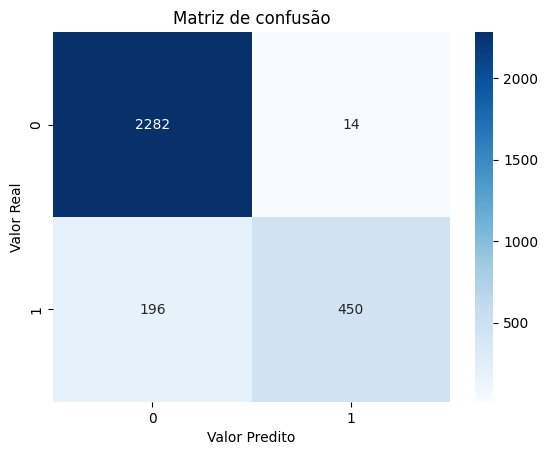

In [14]:
random_forest = RandomForestClassifier(n_estimators=30, criterion="entropy", class_weight={0: 0.2, 1: 0.8}, random_state=47)

modelo_treinado, _, _, _  = treinar_modelo(random_forest, X, y, True)

Média da Precisão (Weighted): 0.937
Média da Revocação (Weighted): 0.935


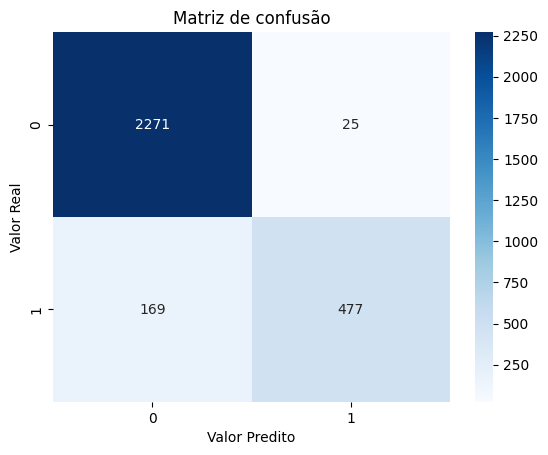

In [15]:
xgboost = XGBClassifier(random_state=47)

xgboost_treinado, _, _, _  = treinar_modelo(xgboost, X, y, True)

Média da Precisão (Weighted): 0.924
Média da Revocação (Weighted): 0.923


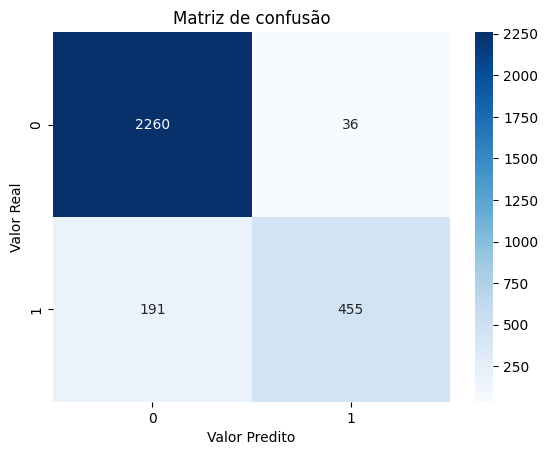

In [16]:
gradient_boost = GradientBoostingClassifier(random_state=47)

gradientboost_treinado, _, _, _  = treinar_modelo(gradient_boost, X, y, True)

### Feature Importance

In [17]:
# verificar a feature importance dos modelos que podem exibir

 ### Feature Selection
- RFE (Recursive Feature Elimination)

In [18]:
# Utilizar RFE para selecionar as features com maior importância

### Tunagem de Hiperparâmetros
Optamos por utilizar a pesquisa bayesiana da biblioteca Optuna


In [21]:
# Optuna -> RandomForestClassifier
def objective(trial):
    # definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0)

    # definir o modelo Random Forest com hiperparâmetros da tentativa atual
    modelo = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        class_weight=pesos, # peso das classes
        random_state=47
    )
    
    # treinar o modelo e exibir performance
    modelo_treinado, X_test, y_test, y_pred = treinar_modelo(modelo, X, y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # pegar a performance deste modelo 
    # Calcular a curva Precision-Recall e AUC
    precisao, revocacao, thresholds = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Retornar o AUC da curva Precision-Recall como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc
    
    #metrica = roc_auc_score(y_test, y_pred_proba)
    
    #return metrica

In [22]:
# executando o estudo de otimização no random forest classifier
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
best_model_random_forest = RandomForestClassifier(**study.best_params)

print("Melhores hiperparâmetros: ", study.best_params)

[I 2024-07-16 21:49:49,340] A new study created in memory with name: no-name-daaffa20-a9fc-4f1a-8938-f27e549cf719
[I 2024-07-16 21:52:51,952] Trial 0 finished with value: 0.9176980965685375 and parameters: {'n_estimators': 130, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 12, 'max_features': 0.7602251478326834}. Best is trial 0 with value: 0.9176980965685375.
[I 2024-07-16 22:01:10,755] Trial 1 finished with value: 0.9378971100635377 and parameters: {'n_estimators': 235, 'max_depth': 9, 'min_samples_split': 12, 'min_samples_leaf': 10, 'max_features': 0.7034712274151846}. Best is trial 0 with value: 0.9176980965685375.
[I 2024-07-16 22:07:37,176] Trial 2 finished with value: 0.9409431937088057 and parameters: {'n_estimators': 216, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 0.43202879054155985}. Best is trial 0 with value: 0.9176980965685375.
[I 2024-07-16 22:10:44,139] Trial 3 finished with value: 0.9400620004099199 and parameters: {'

Melhores hiperparâmetros:  {'n_estimators': 218, 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 17, 'max_features': 0.9964932252317589}


In [ ]:
# Optuna -> XGBoostClassifier
def objective(trial):
    # definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0)
    gamma = trial.suggest_float('gamma', 0.001, 1.0)

    # definir o modelo XGBoost com os hiperparâmetros da tentativa atual
    modelo = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        random_state=47
    )
    
    # treinar o modelo e exibir performance
    modelo_treinado, X_test, y_test, y_pred = treinar_modelo(modelo, X, y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # Calcular a curva Precision-Recall e AUC
    precisao, revocacao, thresholds = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Retornar o AUC da curva Precision-Recall como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [ ]:
# executando o estudo de otimização no xgboost
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
best_model_random_forest = XGBClassifier(**study.best_params)

print("Melhores hiperparâmetros: ", study.best_params)

In [ ]:
# Optuna -> Gradient Boosting Classifier
def objective(trial):
    # definindo o espaço de busca dos hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1.0)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    max_features = trial.suggest_float('max_features', 0.1, 1.0) # ['auto', 'sqrt', 'log2']
    
    modelo = GradientBoostingClassifier(
    max_depth=max_depth,
    n_estimators=n_estimators,
    learning_rate=learning_rate,
    max_features=max_features,
    min_samples_split=min_samples_split,
    min_samples_leaf=min_samples_leaf,
    random_state=47
    )

    # treinar o modelo e exibir performance
    modelo_treinado, X_test, y_test, y_pred = treinar_modelo(modelo, X, y)
    
    y_pred_proba = modelo_treinado.predict_proba(X_test)[:, 1]
    
    # pegar a performance deste modelo 
    # Calcular a curva Precision-Recall e AUC
    precisao, revocacao, thresholds = precision_recall_curve(y_test, y_pred_proba)
    metrica_pr_auc = auc(revocacao, precisao)

    # Retornar o AUC da curva Precision-Recall como a métrica a ser otimizada pelo Optuna
    return metrica_pr_auc

In [ ]:
# executando o estudo de otimização no gradient boosting
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)
best_model_random_forest = GradientBoostingClassifier(**study.best_params)

print("Melhores hiperparâmetros: ", study.best_params)

### Treinando os modelos com os melhores hiperparâmetros

Média da Precisão (Weighted): 0.854
Média da Revocação (Weighted): 0.847


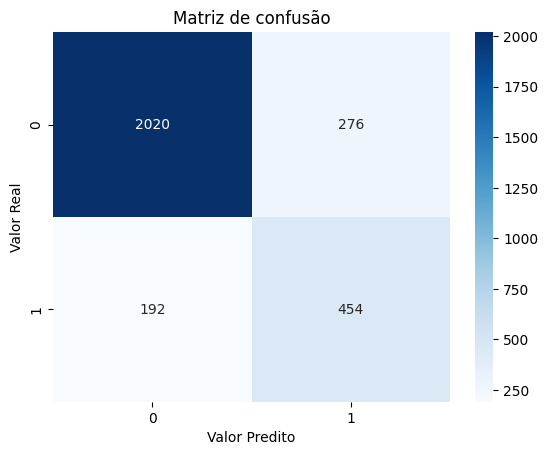

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('gaussiannb',
                  RandomForestClassifier(class_weight={0: 0.6406821745948772,
                                                       1: 2.2770552717138877},
                                         max_depth=2,
                                         max_features=0.9964932252317589,
                                         min_samples_leaf=17,
                                         min_samples_split=15, n_estimators=218,
                                         random_state=47))]),
        idade_cliente  renda_cliente  posse_residencia_cliente  \
 15                23         120000                         0   
 21                22          65000                         0   
 24                24          67746                         0   
 30                25         120000                         0   
 32                25         306000                         0   
 ...              ...            ..

In [34]:
# treinando o random forest classifier
# ROC_AUC_SCORE: {'n_estimators': 218, 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 17, 'max_features': 0.9964932252317589}
random_forest = RandomForestClassifier(
    n_estimators=218,
    max_depth=2,
    min_samples_split=15,
    min_samples_leaf=17,
    max_features=0.9964932252317589,
    class_weight=pesos, # peso das classes
    random_state=47
)

treinar_modelo(random_forest, X, y, True)

In [ ]:
"""# treinando o xgboost classifier
xgboost = XGBClassifier(
    n_estimators=...,
    max_depth=...,
    learning_rate=...,
    gamma=...,
    random_state=47
)

treinar_modelo(xgboost, X, y, True)
"""

In [ ]:
"""# treinando o gradient boosting classifier
gradient_boost = GradientBoostingClassifier(
    max_depth=...,
    n_estimators=...,
    learning_rate=...,
    max_features=...,
    min_samples_split=...,
    min_samples_leaf=...,
    random_state=47
)

treinar_modelo(gradient_boost, X, y, True)
"""

### Modelo escolhido

In [ ]:
# escolher o modelo e exibir a performance dele aqui

In [ ]:
# salvar o modelo em um arquivo pickle
# with open('modelo.pkl', mode='wb') as f:
#    pickle.dump(modelo_treinado, f)

# Análise de Negócio
Revisando a performance do modelo escolhido:
- Score Cross Validation: 
- Average Precision: 
- Precision Score: 
- Recall Score: 
- F1 Score: 
- ROC AUC Score: 

O Recall nos diz que de todos os clientes que de fato não pagaram, o modelo conseguiu acertar XX.xx% dos casos. Contudo, o modelo acertou apenas YY.yy% dos casos em que ele previu que os clientes não pagariam.

Inserindo em um contexto para visualizar a solução da aplicabilidade deste modelo no negócio, temos a proposta abaixo: ~~para os clientes que não possuem histórico de inadimplência~~

Como não sabemos em quanto tempo um cliente pagará o empréstimo ou quanto está pagando por período, utilizaremos o desconto de juros fixo
_______________________________________________
**"Receba 2% de Desconto de Juros Fixo ao pagar o seu empréstimo em dia!"**
_______________________________________________

Supondo que com essa estratégia os clientes que não pagariam, permaneceram pagando por mais 5 meses.
Dito isso, precisamos calcular o lucro líquido e bruto com estes clientes que posteriormente deixariam de pagar o empréstimo.

Devemos selecionar no banco de dados os clientes em que a previsão foi de clientes inadimplentes:

In [ ]:
# selecionar a predição do modelo
# executar a intersecção da predição com o real para criar um dataframe só com a intersecção de pred x real
# localizar os índices destes clientes
# atribuir o dataframe de teste à uma variável: df_X_test_copy
# reproduzir em df_X_test_copy.head()

Aplicando o desconto de 2% no juros anual e multiplicando por 5. Assim saberemos quanto obtemos com a retenção destes clientes.

In [ ]:
# df_X_test_copy['juros_emprestimo'] = df[df['juros_emprestimo'] == df['status_emprestimo'] == 1]

# definir em quanto tempo os clientes iriam pagar os empréstimos com base no percentual_renda_emprestimo
# lucro_liquido = (df_X_test_copy['juros_emprestimo'].values*0.8)*(df_X_test_copy['valor_emprestimo'].values/12*5).sum()

In [ ]:
# lucro_bruto = (df_X_test_copy['valor_emprestimo'].values).sum() - lucro_liquido
# verificar o valor se eles tivessem não pago por esses 5 meses e comparar com se tivessem pago para fazer o valor bruto

## Resultado
Lucro Líquido: R$

Perdas: R$

Lucro Bruto: R$